In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from utils.utils_train import train_supervised, train_models_in_threads, test_model_in_batches
from utils.utils_plots import plot_interesting_features, plot_metrics
from utils.utils_dataset import balance_dataset, prepare_dataset, balance_data_for_clients
from utils.utils_dataset import display_dataset_split
from utils.utils_metrics import calculate_metrics, plot_confusion_matrix, calculate_roc_auc


In [2]:
from model.eGauss_plus import eGAUSSp

In [3]:
# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)

'''
# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to normalize - all except 'Class'
cols_to_normalize = [col for col in data.columns if col != 'Class']

# Apply the normalization
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
'''

"\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Select the columns to normalize - all except 'Class'\ncols_to_normalize = [col for col in data.columns if col != 'Class']\n\n# Apply the normalization\ndata[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])\n"

In [4]:
print(f"{torch.cuda.is_available()}")
device = torch.device("cpu") # torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

True


In [5]:
import itertools
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
import pandas as pd
import concurrent.futures
import threading  # Import the threading module

if False:

    num_clients = 1

    # Define the range of values for each parameter
    num_sigma_values = [5, 10, 12, 20]
    kappa_join_values = [0.3, 0.5, 0.7, 0.8]
    N_r_values = [10, 12, 16, 20, 30]

    # Total number of experiments
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)
    completed_experiments = 0

    # Define other parameters and data setup
    local_model_params = {
        "feature_dim": 30,
        "num_classes": 2,
        "kappa_n": 1,
        "S_0": 1e-10,
        "c_max": 100,
        "num_samples": 200, 
        "device": device  # Make sure 'device' is defined
    }

    # Placeholder for the best parameters and best score
    best_params = None
    best_score = 0

    # List to store all results
    results = []

    # Function to write data to a file
    def write_to_file(file_path, data, mode='a'):
        with open(file_path, mode) as file:
            file.write(data + "\n")

    # Prepare the dataset
    # Assuming prepare_dataset function and data are defined
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    client_train, test_data, all_data = prepare_dataset(X, y, num_clients, balance="centroids")

    # Initialize a lock and a shared variable for progress tracking
    lock = threading.Lock()
    completed_experiments = 0
    total_experiments = len(num_sigma_values) * len(kappa_join_values) * len(N_r_values)

    # Function to execute model training and evaluation
    def train_evaluate_model(params):
        global completed_experiments
        
        num_sigma, kappa_join, N_r = params
        local_model_params.update({"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r})

        local_model = eGAUSSp(**local_model_params)
        train_supervised(local_model, client_train[0])

        _, pred_max, _ = test_model_in_batches(local_model, test_data, batch_size = 1000)
        metrics = calculate_metrics(pred_max, test_data, weight="binary")
        f1_score = metrics["f1_score"]

        result_str = f"num_sigma={num_sigma}, kappa_join={kappa_join}, N_r={N_r}, F1 Score: {f1_score}"
        print(result_str)
        write_to_file("experiment_results.txt", result_str)  # Write results to file
        
        # Update progress
        with lock:
            completed_experiments += 1
            progress = (completed_experiments / total_experiments) * 100
            print(f"Progress: {completed_experiments}/{total_experiments} ({progress:.2f}%)")

        return {"num_sigma": num_sigma, "kappa_join": kappa_join, "N_r": N_r, "f1_score": f1_score}
        

    # Write initial setup data to file
    initial_setup_str = f"Initial Setup: num_clients={num_clients}, num_sigma_values={num_sigma_values}, kappa_join_values={kappa_join_values}, N_r_values={N_r_values}"
    write_to_file("experiment_results.txt", initial_setup_str, mode='w')  # 'w' to overwrite if exists

    # Using ThreadPoolExecutor to run in multiple threads
    with concurrent.futures.ThreadPoolExecutor() as executor:
        param_combinations = list(itertools.product(num_sigma_values, kappa_join_values, N_r_values))
        results = list(executor.map(train_evaluate_model, param_combinations))

    # Find best parameters and score
    best_result = max(results, key=lambda x: x["f1_score"])
    best_score = best_result["f1_score"]
    best_params = {k: best_result[k] for k in ["num_sigma", "kappa_join", "N_r"]}

    # After completing all experiments, print final results
    print(f"Best F1 Score: {best_score}")
    print(f"Best Parameters: {best_params}")
    results_df = pd.DataFrame(results)

'''
    # Creating a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=results_df['num_sigma'],
        y=results_df['kappa_join'],
        z=results_df['N_r'],
        mode='markers',
        marker=dict(
            size=5,
            color=results_df['f1_score'],  # Set color to the F1 scores
            colorscale='Viridis',  # Choose a colorscale
            opacity=0.8,
            colorbar=dict(title='F1 Score')
        )
    )])

    # Adding labels and title
    fig.update_layout(
        scene=dict(
            xaxis_title='num_sigma',
            yaxis_title='kappa_join',
            zaxis_title='N_r'
        ),
        title='F1 Score for Different Parameter Combinations'
    )

    fig.show()
'''

"\n    # Creating a 3D scatter plot\n    fig = go.Figure(data=[go.Scatter3d(\n        x=results_df['num_sigma'],\n        y=results_df['kappa_join'],\n        z=results_df['N_r'],\n        mode='markers',\n        marker=dict(\n            size=5,\n            color=results_df['f1_score'],  # Set color to the F1 scores\n            colorscale='Viridis',  # Choose a colorscale\n            opacity=0.8,\n            colorbar=dict(title='F1 Score')\n        )\n    )])\n\n    # Adding labels and title\n    fig.update_layout(\n        scene=dict(\n            xaxis_title='num_sigma',\n            yaxis_title='kappa_join',\n            zaxis_title='N_r'\n        ),\n        title='F1 Score for Different Parameter Combinations'\n    )\n\n    fig.show()\n"

In [6]:
# Model parameters
local_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 10,
    "kappa_join": 0.5,
    "S_0": 1e-10,
    "N_r": 20,
    "c_max": 300,
    "num_samples": 1000,
    "device": device
}

federated_model_params = {
    "feature_dim": 30,
    "num_classes": 2,
    "kappa_n": 1,
    "num_sigma": 10,
    "kappa_join": 0.5,
    "S_0": 1e-10,
    "N_r": 20,
    "c_max": 100,
    "num_samples": 1000,
    "device": device
}

In [7]:

#display_dataset_split(client_train, test_data)
#plot_dataset_split(client_train, test_data)

In [8]:
def compare_models(model1, model2):
    differences = []

    # Function to find differing indices within the overlapping range
    def find_differing_indices(tensor1, tensor2):
        min_length = min(tensor1.size(0), tensor2.size(0))
        differing = (tensor1[:min_length] != tensor2[:min_length]).nonzero(as_tuple=False)
        if differing.nelement() == 0:
            return "No differences"
        else:
            return differing.view(-1).tolist()  # Flatten and convert to list

    # Compare mu parameter and find differing indices
    mu_equal = torch.equal(model1.mu[:model1.c], model2.mu[:model2.c])
    if not mu_equal:
        differing_indices_mu = find_differing_indices(model1.mu[:model1.c], model2.mu[:model2.c])
        differences.append(f"mu parameter differs at indices {differing_indices_mu}")

    # Compare S parameter and find differing indices
    S_equal = torch.equal(model1.S[:model1.c], model2.S[:model2.c])
    if not S_equal:
        differing_indices_S = find_differing_indices(model1.S[:model1.c], model2.S[:model2.c])
        differences.append(f"S parameter differs at indices {differing_indices_S}")

    # Compare n parameter and find differing indices
    n_equal = torch.equal(model1.n[:model1.c], model2.n[:model2.c])
    if not n_equal:
        differing_indices_n = find_differing_indices(model1.n[:model1.c], model2.n[:model2.c])
        differences.append(f"n parameter differs at indices {differing_indices_n}")

    # Check if there are any differences
    if differences:
        difference_str = ", ".join(differences)
        return False, f"Differences found in: {difference_str}"
    else:
        return True, "Models are identical"


In [9]:
def write_to_file(file_path, data, mode='a'):
    with open(file_path, mode) as file:
        file.write(data + "\n")


In [10]:

def run_experiment(num_clients, num_rounds, client_raw_data, test_data, balance):
       
    # Initialize a model for each client
    local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]
    federated_model = eGAUSSp(**federated_model_params)

    # Initialize a list to store the metrics for each round
    round_metrics = []
    result_file = "experiment_results.txt"

    for round in range(num_rounds):
        print(f"--- Communication Round {round + 1} ---")
        round_info = f"--- Communication Round {round + 1} ---\n"

        # Reset client metrics for the new round
        client_metrics = []

        client_train = balance_data_for_clients(client_raw_data, local_models, balance, round)

        display_dataset_split(client_train, test_data)
        
        aggregated_model = eGAUSSp(**federated_model_params)
        federated_model = eGAUSSp(**federated_model_params)

        # Train local models
        train_models_in_threads(local_models, client_train)

        # Initialize dictionary to store metrics for this round
        # Initialize dictionary to store metrics for this round
        '''
        for local_model, client_data in zip(local_models, clients_data):
             train_supervised(local_model, client_data)

             print(f"Number of local model clusters = {sum(local_model.n[0:local_model.c]> local_model.kappa_n)}")
             all_scores, pred_max, _ = test_model_in_batches(local_model, client_data)
             binary = calculate_metrics(pred_max, client_data, "binary")
             roc_auc = calculate_roc_auc(all_scores, client_data)
             print(f"Test Metrics: {binary}")
             print(f"Test ROC AUC: {roc_auc}")
             plot_confusion_matrix(pred_max, client_data)
        '''   

        # Update federated model with local models
        for client_idx, client_model in enumerate(local_models):

            print(f"Number of local model clusters = {sum(client_model.n[0:client_model.c]> 0)}")
            # Run the forward function on the training data
            
            # Calculate and collect metrics for each client model
            client_scores, client_pred, _ = test_model_in_batches(client_model, client_train[client_idx], batch_size=500)
            client_binary = calculate_metrics(client_pred, client_train[client_idx], "binary")
            client_roc_auc = calculate_roc_auc(client_scores, client_train[client_idx])

            print(f"Test Metrics: {client_binary}")
            print(f"Test ROC AUC: {client_roc_auc}")
           # plot_confusion_matrix(pred_max, clients_data[client_idx])
            
            # Calculate additional metrics for each client
            client_metrics.append({
                'client_idx': client_idx,
                'binary': client_binary,
                'roc_auc': client_roc_auc,
                'clusters': sum(client_model.n[0:client_model.c].cpu()> 0)
            })

            #client_model.federal_agent.federated_merging()
            #print(f"Number of local model clusters after merging = {sum(client_model.n[0:client_model.c]> client_model.kappa_n)}")

            #client_model.federal_agent.federated_merging()
            print(f"Updating agreggated model with client {client_idx + 1}")

            aggregated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n, pred_min = 0)
            print(f"Number of agreggated clusters after transfer = {sum(aggregated_model.n[0:aggregated_model.c]> aggregated_model.kappa_n)}")
                
                
        #client_model.score = 0*client_model.score  
        #aggregated_model.S_glo = client_model.S_glo
        #aggregated_model.mu_glo = client_model.mu_glo     
        
        #if round>1:
        #    with torch.no_grad():
        #        aggregated_model.S = nn.Parameter(aggregated_model.S/2)
        #        aggregated_model.n = nn.Parameter(aggregated_model.n/num_clients)

        #        aggregated_model.S_glo = aggregated_model.S_glo/2
        #        aggregated_model.n_glo = aggregated_model.n_glo/num_clients
        

        # New code for comparison using the updated compare_models function
        #are_models_same, comparison_message = compare_models(client_model, aggregated_model)
        #print(f"Comparison details: {comparison_message}")

        # Update federated model with local models
        print(f"Updating federated model with agreggated model")

        federated_model.federal_agent.merge_model_privately(aggregated_model, federated_model.kappa_n, pred_min = 0)
        print(f"Number of federated clusters after transfer = {sum(federated_model.n[0:federated_model.c] > federated_model.kappa_n)}")
        
        federated_model.federal_agent.federated_merging()
        print(f"Number of agreggated clusters after merging = {sum(federated_model.n[0:federated_model.c]> federated_model.kappa_n)}")
        
        #local_models = [eGAUSSp(**local_model_params) for _ in range(num_clients)]  
        
        # Perform federated merging and removal mechanism on the federated model
        if any(federated_model.n[0:federated_model.c]> federated_model.kappa_n):

            # Evaluate federated model
            fed_scores, fed_pred, _ = test_model_in_batches(federated_model, test_data, batch_size=500)
            fed_binary = calculate_metrics(fed_pred, test_data, "binary")
            fed_roc_auc = calculate_roc_auc(fed_scores, test_data)
            print(f"Test Metrics: {fed_binary}")
            print(f"Test ROC AUC: {fed_roc_auc}")

            #plot_confusion_matrix(pred_max_fed, test_data)

            round_metrics.append({
                'round': round + 1,
                'federated_model': {
                    'clusters': sum(federated_model.n[0:federated_model.c].cpu() > federated_model.kappa_n),
                    'binary': fed_binary,
                    'roc_auc': fed_roc_auc
                },
                'aggregated_model': {
                    'clusters': sum(aggregated_model.n[0:aggregated_model.c].cpu() > aggregated_model.kappa_n),
                },
                'client_metrics': client_metrics
            })

        # Return the updated federated model to each client
        for client_idx in range(len(local_models)):
            print(f"Returning updated model to client {client_idx + 1}")
            
            local_models[client_idx].federal_agent.merge_model_privately(federated_model, federated_model.kappa_n, pred_min = 0)
            #local_models[client_idx].federal_agent.federated_merging()

            #local_models[client_idx].score = torch.ones_like(local_models[client_idx].score)
            #local_models[client_idx].num_pred = torch.zeros_like(local_models[client_idx].num_pred)

            '''
            # Return the updated federated model to each client
            for client_idx, client_model in enumerate(local_models):
                print(f"Returning updated model to client {client_idx + 1}")
                client_model.federal_agent.merge_model_privately(federated_model, federated_model.kappa_n)
                client_model.federal_agent.federated_merging()
            '''
            
          # Print and write round information to file
        round_info = f"--- End of Round {round + 1} ---\n"
        print(round_info)
        write_to_file(result_file, round_info)

        # Plot features for the current round
        plt.close('all')  # Close all existing plots to free up memory
        if True:
            plot_interesting_features(client_train[0], model=federated_model, num_sigma=federated_model.num_sigma, N_max=federated_model.kappa_n)   
            #plot_interesting_features(test_data, model=federated_model, num_sigma=federated_model.num_sigma, N_max=federated_model.kappa_n)   

        # Iterate over each round's metrics and write to file
        for metric in round_metrics:
            metric_info = f"Round {metric['round']}: Metrics: {metric['federated_model']['binary']}, ROC AUC: {metric['federated_model']['roc_auc']}\n"
            print(metric_info)  # Print each round's metrics
            write_to_file(result_file, metric_info)  # Write to file

    # After all rounds
    final_info = "All Rounds Completed. Metrics Collected:\n"
    print(final_info)
    write_to_file(result_file, final_info)

    # Iterate over each round's metrics and write to file
    for metric in round_metrics:
        metric_info = f"Round {metric['round']}: "
        metric_info += f"Federated Model - Clusters: {metric['federated_model']['clusters']}, "
        metric_info += f"Binary Metrics: {metric['federated_model']['binary']}, ROC AUC: {metric['federated_model']['roc_auc']}\n"
        metric_info += f"Aggregated Model - Clusters: {metric['aggregated_model']['clusters']}\n"

        for client_metric in metric['client_metrics']:
            metric_info += f"Client {client_metric['client_idx']} - Binary: {client_metric['binary']}, ROC AUC: {client_metric['roc_auc']}\n"

        print(metric_info)  # Print each round's metrics
        write_to_file(result_file, metric_info)  # Write to file

    return round_metrics


Running experiment with 3 clients and data configuration 1
--- Communication Round 1 ---
Client 1: {0: 132, 1: 132}
Client 2: {0: 131, 1: 131}
Client 3: {0: 131, 1: 131}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 57258 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 57750
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Number of local model clusters = 237
Evolving has been disabled.
Test Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Test ROC AUC: 0.9540863177226813
Updating agreggated model with client 1
Updated var_glo values: tensor(2.3124e+09)
Number of agreggated clusters after transfer = 19
Number of local model clusters = 222
Evolving has been disabled.
Test Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Test ROC AUC: 0.9707476254297536
Updati

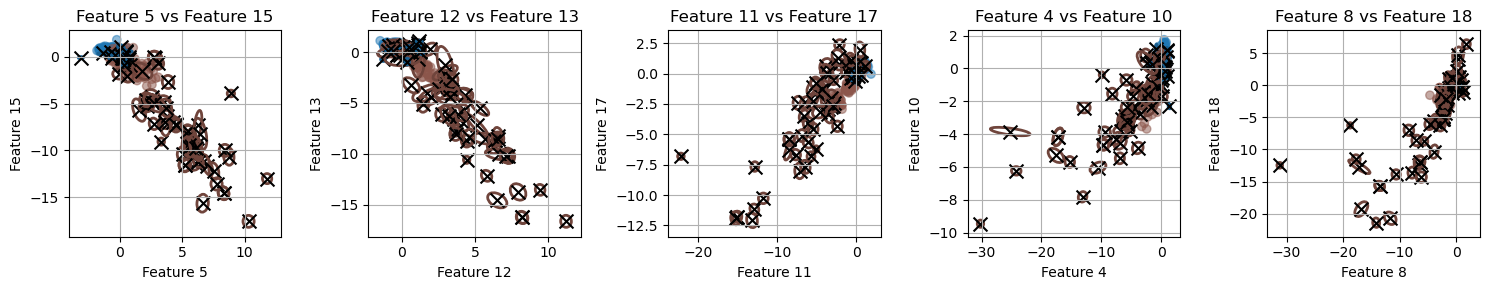

Round 1: Metrics: {'accuracy': 0.1475720655875847, 'precision': 0.0019937515415604703, 'recall': 0.9897959183673469, 'f1_score': 0.00397948717948718}, ROC AUC: 0.9631671305973148

--- Communication Round 2 ---
Evolving has been disabled.
Evolving has been disabled.
Evolving has been disabled.
Client 1: {0: 264, 1: 132}
Client 2: {0: 262, 1: 131}
Client 3: {0: 262, 1: 131}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 57652 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 58144
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Number of local model clusters = 408
Evolving has been disabled.
Test Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Test ROC AUC: 0.9283459595959596
Updating agreggated model with client 1
Updated var_glo values: tensor(2.2938e+09)
Number of agreggated clusters a

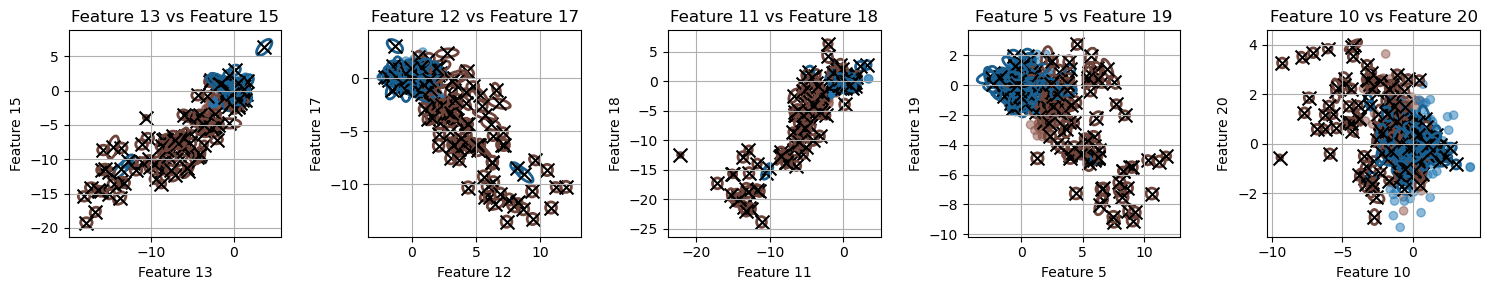

Round 1: Metrics: {'accuracy': 0.1475720655875847, 'precision': 0.0019937515415604703, 'recall': 0.9897959183673469, 'f1_score': 0.00397948717948718}, ROC AUC: 0.9631671305973148

Round 2: Metrics: {'accuracy': 0.9940311084582705, 'precision': 0.18652849740932642, 'recall': 0.7346938775510204, 'f1_score': 0.2975206611570248}, ROC AUC: 0.8476493861472558

--- Communication Round 3 ---
Evolving has been disabled.
Evolving has been disabled.
Evolving has been disabled.
Client 1: {0: 264, 1: 132}
Client 2: {0: 262, 1: 131}
Client 3: {0: 262, 1: 131}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 57652 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 58144
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enabled.
Number of local model clusters = 463
Evolving has been disabled.
Test Metrics: {'accuracy': 0.9949494949494949, 'prec

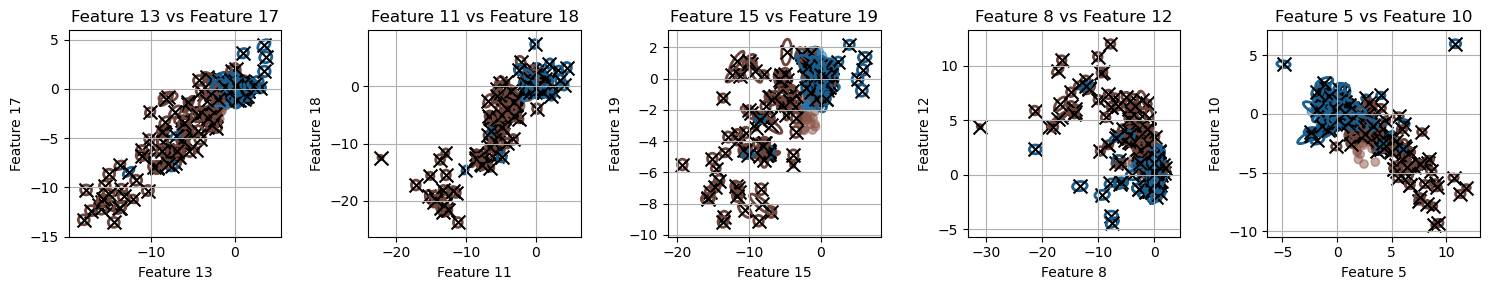

Round 1: Metrics: {'accuracy': 0.1475720655875847, 'precision': 0.0019937515415604703, 'recall': 0.9897959183673469, 'f1_score': 0.00397948717948718}, ROC AUC: 0.9631671305973148

Round 2: Metrics: {'accuracy': 0.9940311084582705, 'precision': 0.18652849740932642, 'recall': 0.7346938775510204, 'f1_score': 0.2975206611570248}, ROC AUC: 0.8476493861472558

Round 3: Metrics: {'accuracy': 0.9989642217618764, 'precision': 0.7532467532467533, 'recall': 0.5918367346938775, 'f1_score': 0.6628571428571429}, ROC AUC: 0.8391387470857786

--- Communication Round 4 ---
Evolving has been disabled.
Evolving has been disabled.
Evolving has been disabled.
Client 1: {0: 264, 1: 132}
Client 2: {0: 262, 1: 131}
Client 3: {0: 262, 1: 131}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 57652 samples
Class 1: 492 samples

Total Number of Samples Across All Datasets: 58144
Debugging has been disabled.
Evolving has been enabled.
Debugging has been disabled.
Evolving has been enable

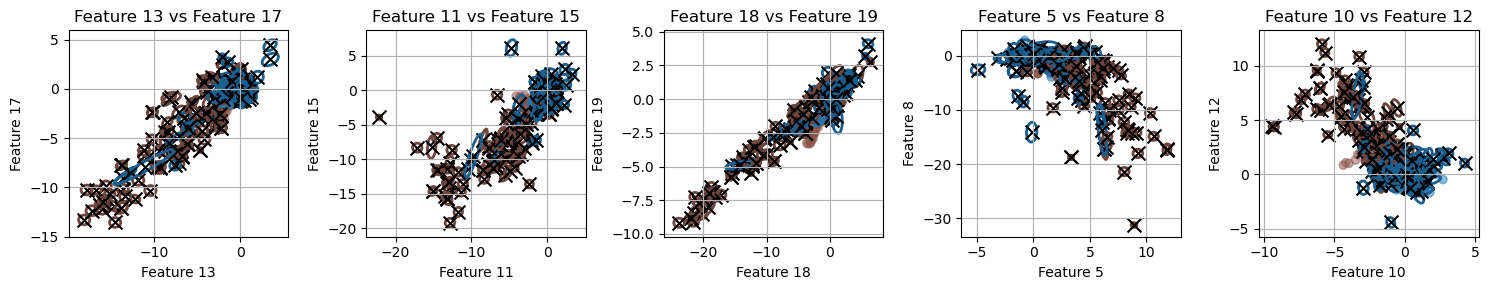

Round 1: Metrics: {'accuracy': 0.1475720655875847, 'precision': 0.0019937515415604703, 'recall': 0.9897959183673469, 'f1_score': 0.00397948717948718}, ROC AUC: 0.9631671305973148

Round 2: Metrics: {'accuracy': 0.9940311084582705, 'precision': 0.18652849740932642, 'recall': 0.7346938775510204, 'f1_score': 0.2975206611570248}, ROC AUC: 0.8476493861472558

Round 3: Metrics: {'accuracy': 0.9989642217618764, 'precision': 0.7532467532467533, 'recall': 0.5918367346938775, 'f1_score': 0.6628571428571429}, ROC AUC: 0.8391387470857786

Round 4: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.75, 'recall': 0.4897959183673469, 'f1_score': 0.5925925925925924}, ROC AUC: 0.8334643596465036

--- Communication Round 5 ---
Evolving has been disabled.
Evolving has been disabled.
Evolving has been disabled.
Client 1: {0: 264, 1: 132}
Client 2: {0: 262, 1: 131}
Client 3: {0: 262, 1: 131}
Test Set: {0: 56864, 1: 98}

Combined Number of Samples per Class:
Class 0: 57652 samples
Class 1: 492 samples

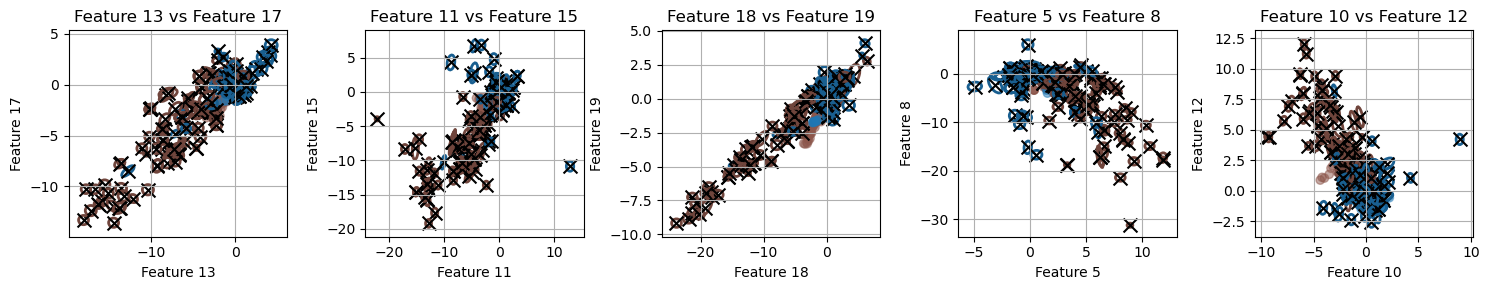

Round 1: Metrics: {'accuracy': 0.1475720655875847, 'precision': 0.0019937515415604703, 'recall': 0.9897959183673469, 'f1_score': 0.00397948717948718}, ROC AUC: 0.9631671305973148

Round 2: Metrics: {'accuracy': 0.9940311084582705, 'precision': 0.18652849740932642, 'recall': 0.7346938775510204, 'f1_score': 0.2975206611570248}, ROC AUC: 0.8476493861472558

Round 3: Metrics: {'accuracy': 0.9989642217618764, 'precision': 0.7532467532467533, 'recall': 0.5918367346938775, 'f1_score': 0.6628571428571429}, ROC AUC: 0.8391387470857786

Round 4: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.75, 'recall': 0.4897959183673469, 'f1_score': 0.5925925925925924}, ROC AUC: 0.8334643596465036

Round 5: Metrics: {'accuracy': 0.9990519995786665, 'precision': 0.8055555555555556, 'recall': 0.5918367346938775, 'f1_score': 0.6823529411764706}, ROC AUC: 0.8249000658929864

--- Communication Round 6 ---
Evolving has been disabled.
Evolving has been disabled.
Evolving has been disabled.
Client 1: {0: 2

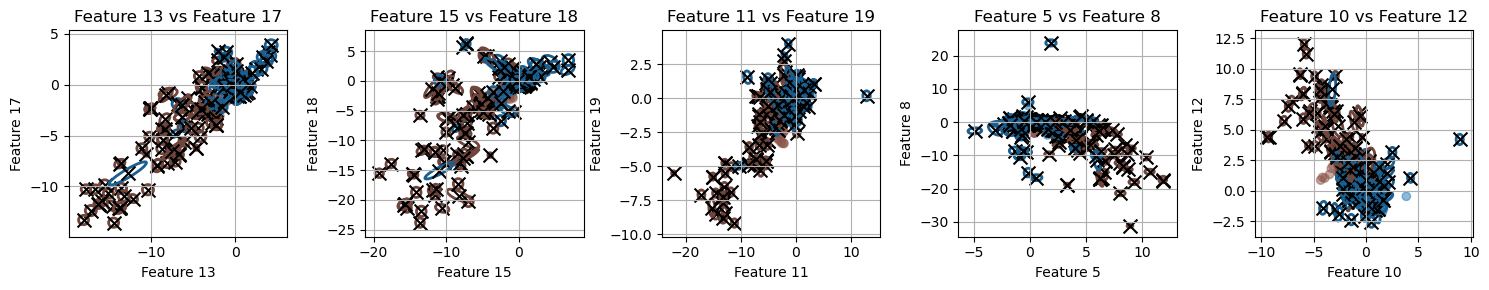

Round 1: Metrics: {'accuracy': 0.1475720655875847, 'precision': 0.0019937515415604703, 'recall': 0.9897959183673469, 'f1_score': 0.00397948717948718}, ROC AUC: 0.9631671305973148

Round 2: Metrics: {'accuracy': 0.9940311084582705, 'precision': 0.18652849740932642, 'recall': 0.7346938775510204, 'f1_score': 0.2975206611570248}, ROC AUC: 0.8476493861472558

Round 3: Metrics: {'accuracy': 0.9989642217618764, 'precision': 0.7532467532467533, 'recall': 0.5918367346938775, 'f1_score': 0.6628571428571429}, ROC AUC: 0.8391387470857786

Round 4: Metrics: {'accuracy': 0.9988413328183702, 'precision': 0.75, 'recall': 0.4897959183673469, 'f1_score': 0.5925925925925924}, ROC AUC: 0.8334643596465036

Round 5: Metrics: {'accuracy': 0.9990519995786665, 'precision': 0.8055555555555556, 'recall': 0.5918367346938775, 'f1_score': 0.6823529411764706}, ROC AUC: 0.8249000658929864

Round 6: Metrics: {'accuracy': 0.9989817773252344, 'precision': 0.7941176470588235, 'recall': 0.5510204081632653, 'f1_score': 0.6

: 

In [11]:
# List of client counts and data configuration indices
client_counts = [ 3]
data_config_indices = [1]  # Replace with your actual data configuration indices

# Assuming local_models, client_train, federated_model, and test_data are already defined
# Number of communication rounds
num_rounds = 100
profiler = False
experiments = []
# Running the experiment
for num_clients in client_counts:
    for data_config_index in data_config_indices:
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
        client_train, test_data, all_data = prepare_dataset(X, y, num_clients) 
        balance= None
        if data_config_index == 1:

            balance = 'random'
                #'random': RandomUnderSampler(random_state=None),
                #'tomek': TomekLinks(),
                #'centroids': ClusterCentroids(random_state=None),
                #'nearmiss': NearMiss(version=2),
                #'enn': AllKNN(sampling_strategy='all'), NO
                #'smote': SMOTE(random_state=None), NO
                #'one_sided_selection': OneSidedSelection(random_state=None), NO
                #'ncr': NeighbourhoodCleaningRule(), NO
                #'function_sampler': FunctionSampler(),  # Identity resampler NO
                #'instance_hardness_threshold': InstanceHardnessThreshold(estimator=LogisticRegression(), random_state=0),
        elif data_config_index == 2:    
             balance = 'Smote'       
        elif data_config_index == 3:

            balance = None
        
        print(f"Running experiment with {num_clients} clients and data configuration {data_config_index}")
        if profiler:
                        
            import cProfile
            %load_ext memory_profiler
            import yappi

            print(f"... with profiler")
            pr = cProfile.Profile()
            pr.enable()
            yappi.start()
            metrics = run_experiment(num_clients, num_rounds, client_train, test_data, balance)
            yappi.stop()
            pr.disable()

            pr.print_stats(sort='cumtime')
            yappi.get_thread_stats().print_all()
            yappi.get_func_stats().print_all()   
                   
        else:
            metrics = run_experiment(num_clients, num_rounds, client_train, test_data, balance)
            
        experiments.append(metrics)
            
        plot_metrics(experiments, client_counts, data_config_indices)

In [ ]:
plot_metrics(experiments, client_counts, data_config_indices)

In [ ]:
'''
for client_idx, client_model in enumerate(local_models):
        print(f"Merging client {client_idx + 1}")
        #print(f"Number of client {client_idx + 1} clusters before merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        #client_model.federal_agent.federated_merging() 
        print(f"Number of client {client_idx + 1} after merging = {torch.sum(client_model.n[:client_model.c]>client_model.kappa_n)}")
        federated_model.federal_agent.merge_model_privately(client_model, client_model.kappa_n)

print(f"Number of clusters after transfer = {federated_model.c}")
'''

In [ ]:
'''
federated_model.federal_agent.federated_merging()
federated_model.removal_mech.removal_mechanism()
print(f"Number of clusters after merging = {federated_model.c}")
'''

In [ ]:

'''
print(f"\nTesting federated model")   

all_scores, pred_max, _ = test_model(federated_model, test_data)
metrics = calculate_metrics(pred_max, test_data, "binary")
print(f"Test Metrics: {metrics}")
roc_auc = calculate_roc_auc(all_scores, test_data)
print(f"Test ROC AUC: {roc_auc}")

plot_confusion_matrix(pred_max, test_data)
'''

In [ ]:

'''
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion matrix values
tn = 135
fn = 10
tp = 132
fp = 19

# Creating the confusion matrix
y_true = [0]*tn + [1]*fn + [1]*tp + [0]*fp  # 0 for negative class, 1 for positive class
y_pred = [0]*(tn+fn) + [1]*(fp+tp)  # Predictions

# Calculating metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(accuracy, precision, recall, f1)
'''